## ДЗ  Digit Recognizer  
https://www.kaggle.com/c/digit-recognizer

Распознавание рукописного ввода на примере базы MNIST

Построить классификатор изображений рукописного ввода на базе MNIST. В качестве шаблона в данной работе можно использовать ipython-ноутбук 002-digit.ipynb.

Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.

В качестве модели классификатора можно использовать любую известную Вам модель, за исключением сверточных нейронных сетей.

Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше 0.6. Метрика оценивается на тестовой выборке в рамках контеста Digit Recognizer на Kaggle.

Решение необходимо предоставить в виде ipython-ноутбука с реализацией процесса построения модели и скриншота с финальным результатом на Kaggle.

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)


In [3]:
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [4]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

## Визуализируем исходные данные

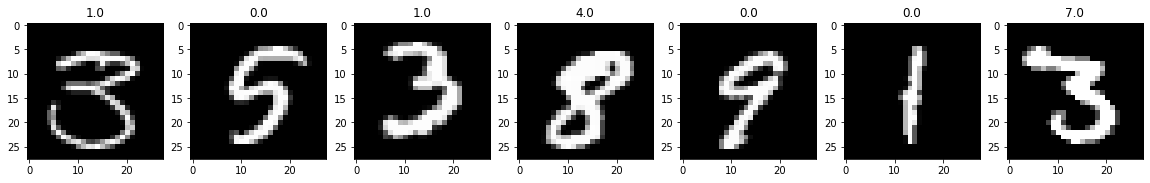

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[7:14], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [6]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [7]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

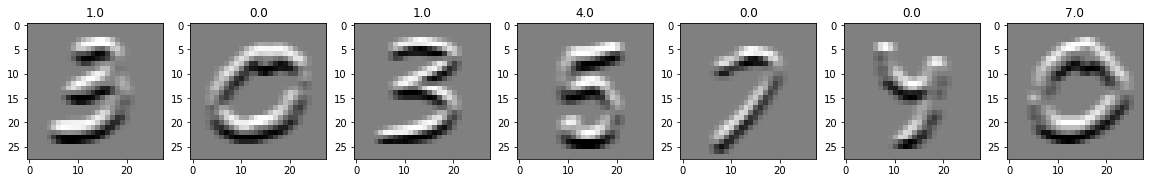

In [8]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_sobel_y[7:14], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

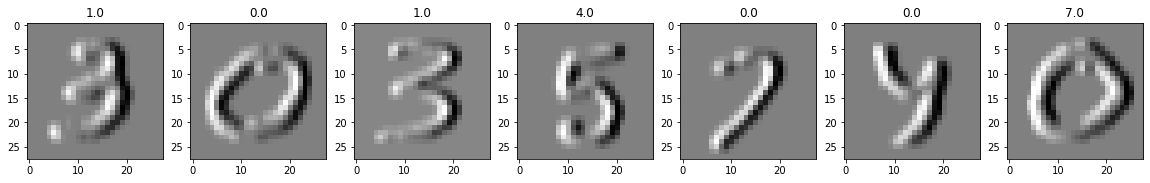

In [9]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_sobel_x[7:14], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем угол и длину вектора градиента

In [10]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [11]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

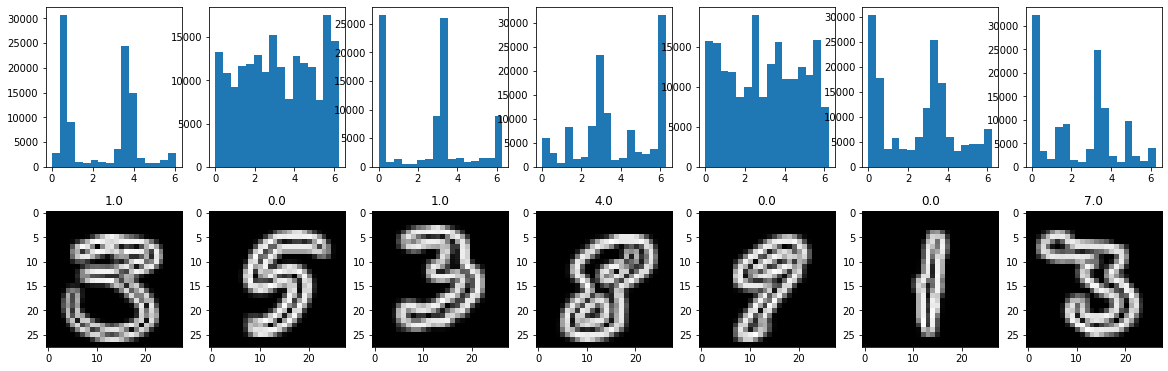

In [12]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[7:14], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [13]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [14]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [15]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [16]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Задаем параметры для вычисления дескриптора

In [17]:
winSize = (28,28)
blockSize = (14,14)
blockStride = (14,14)
cellSize = (7,7)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64

hog = cv2.HOGDescriptor(winSize,
                        blockSize,
                        blockStride,
                        cellSize,
                        nbins,
                        derivAperture,
                        winSigma,
                        histogramNormType,
                        L2HysThreshold,
                        gammaCorrection,
                        nlevels)

## Вычисляем дескриптор для изображения

In [18]:
train_descriptor = np.zeros((len(train_img), 144))
for i in range(len(train_img)):
    train_descriptor[i] = hog.compute(np.uint8(train_img[i])).reshape(-1)
    
test_descriptor = np.zeros((len(test_img), 144))
for i in range(len(test_img)):
    test_descriptor[i] = hog.compute(np.uint8(test_img[i])).reshape(-1)

## Разбиваем выборку на обучение и валидацию

In [19]:

from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore") 

## Строим классификатор по данных гистограммы градиентов

In [20]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

In [21]:
clf_rf = RandomForestClassifier(n_estimators=30, max_depth=30, min_samples_leaf=3, max_features=8, n_jobs=-1)
clf_rf.fit(x_train, y_train)   
y_predict = clf_rf.predict(x_val)

mse_rf2 = mean_squared_error(y_val, y_predict)
sqrt_mse_rf2 = np.sqrt(mse_rf2)

print("MSE: ", mse_rf2)
print("SQ MSE: ", sqrt_mse_rf2)
print('Accuracy: %s' % accuracy_score(y_val, y_predict))

MSE:  7.637142857142857
SQ MSE:  2.7635381048834584
Accuracy: 0.6377380952380952


In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_predict))

              precision    recall  f1-score   support

         0.0       0.43      0.39      0.41       816
         1.0       0.97      0.96      0.97       909
         2.0       0.50      0.47      0.49       846
         3.0       0.64      0.68      0.66       937
         4.0       0.71      0.68      0.70       839
         5.0       0.61      0.65      0.63       702
         6.0       0.47      0.46      0.46       785
         7.0       0.86      0.78      0.82       893
         8.0       0.50      0.56      0.53       835
         9.0       0.63      0.69      0.66       838

    accuracy                           0.64      8400
   macro avg       0.63      0.63      0.63      8400
weighted avg       0.64      0.64      0.64      8400



In [25]:
y_predict_test_hist = clf_rf.predict(test_hist)

In [26]:
y_predict_test_hist

array([2., 5., 9., ..., 3., 9., 3.])

## Строим классификатор по данных дескриптора изображения

In [27]:
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_descriptor, test_size=0.2,
    random_state=42)

In [28]:
clf_rf = RandomForestClassifier(n_estimators=30, max_depth=30, min_samples_leaf=3, max_features=8, n_jobs=-1)
clf_rf.fit(x_train, y_train)   
y_predict = clf_rf.predict(x_val)

mse_rf2 = mean_squared_error(y_val, y_predict)
sqrt_mse_rf2 = np.sqrt(mse_rf2)

print("MSE: ", mse_rf2)
print("SQ MSE: ", sqrt_mse_rf2)
print('Accuracy: %s' % accuracy_score(y_val, y_predict))

MSE:  0.6440476190476191
SQ MSE:  0.8025257746936351
Accuracy: 0.9605952380952381


In [29]:
print(classification_report(y_val, y_predict))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       816
         1.0       0.98      0.99      0.98       909
         2.0       0.95      0.96      0.96       846
         3.0       0.96      0.96      0.96       937
         4.0       0.96      0.96      0.96       839
         5.0       0.97      0.96      0.96       702
         6.0       0.97      0.98      0.98       785
         7.0       0.95      0.95      0.95       893
         8.0       0.95      0.94      0.95       835
         9.0       0.94      0.94      0.94       838

    accuracy                           0.96      8400
   macro avg       0.96      0.96      0.96      8400
weighted avg       0.96      0.96      0.96      8400



In [30]:
y_predict_test = clf_rf.predict(test_descriptor)

In [31]:
y_predict_test

array([2., 0., 9., ..., 3., 9., 2.])

In [32]:
y_predict_test = y_predict_test.astype(np.uint8)

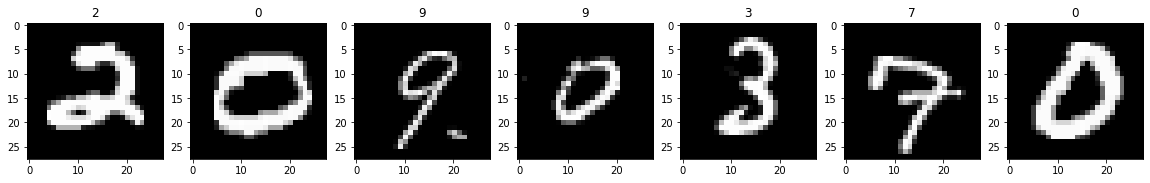

In [33]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:7], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % y_predict_test[i - 1]);

In [34]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(y_predict_test, 1):
        dst.write('%s,%s\n' % (i, p))

## Результаты проверки на Kaggle

### Your submission scored 0.60839  
- вариант с BaggingClassifier по гистограмме градиентов

### Your submission scored 0.62967 
- вариант с RandomForestClassifier по гистограмме градиентов

### Your submission scored 0.95892, which is an improvement of your previous score of 0.62967. 
-  RandomForestClassifier на основе HOGDescriptor